### Notebook to test out vortex tracking from WRF TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
June 2022

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import sys
import cartopy
# from smooth_runn_mn import smooth_runn_mn
from scipy import ndimage
from object_track import object_track
# import cmocean
# from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
# from stratiform_index import stratiform_index

#### Directories

In [2]:
# figdir = "/Users/jruppert/code/tc_figs/"
figdir = "/Users/jamesruppert/code/git/tc_figs/"

main = "/Users/jamesruppert/code/tc_output/"
# main = "/Users/jruppert/code/tc_output/"
main+= 'haiyan' #!ls $main
# print(storm)

# istorm=storm[0]
# memb = !ls $main/$istorm
# imemb=memb[0]
# print(main+istorm+'/'+imemb)

# datdir = main+istorm+'/'+imemb+'/ctl/'
datdir = main+'/memb_01/ctl/'
print(datdir)

/Users/jamesruppert/code/tc_output/haiyan/memb_01/ctl/


#### Read variables

In [3]:
# LonLat
fil = Dataset(datdir+'../../LATLON.nc') # this opens the netcdf file
lon = fil.variables['XLONG'][:] # deg
lon1d=lon[0,:]
lat = fil.variables['XLAT'][:] # deg
lat1d=lat[:,0]
fil.close()
llshape=np.shape(lon)
nx = llshape[1]
ny = llshape[0]

# Pressure
fil = Dataset(datdir+'U.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
fil.close()
# nz = np.shape(pres)[0]

In [4]:
# Level selection
ptrack=600 # tracking pressure level
ikread = np.where(pres == ptrack)[0][0]
print('Tracking at:',round(pres[ikread]),'hPa')

Tracking at: 600 hPa


In [5]:
# Horizontal wind
ufil = Dataset(datdir+'U.nc') # this opens the netcdf file
u = ufil.variables['U'][:,ikread,:,:] # m/s
ufil.close()
vfil = Dataset(datdir+'V.nc') # this opens the netcdf file
v = vfil.variables['V'][:,ikread,:,:] # m/s
vfil.close()

nt=np.shape(u)[0]

#### Calculate relative vorticity

$\zeta=\hat k \cdot \nabla \times \vec{U} = \dfrac{\partial v}{\partial x} - \dfrac{\partial u}{\partial y}$

For spherical: $\dfrac{\partial}{\partial y} \rightarrow \dfrac{\partial}{a\partial \Phi}$ and $\dfrac{\partial}{ \partial x} \rightarrow \dfrac{\partial}{a \text{cos}(\Phi) \partial \lambda}$, where $\lambda$ is longitude, $a$ is Earth radius, and $\Phi$ is latitude.

In [6]:
np.shape(v)

(169, 740, 1400)

In [7]:
a = 6371e3 # Earth radius, m
inva = 1./a
inv_cos = 1./np.cos(np.radians(lat1d))

dudy = np.gradient(u,lat1d,axis=1) * inva
dvdx = np.gradient(v,lon1d,axis=2) * inv_cos[np.newaxis,:,np.newaxis] * inva

# print("Shape of gradient variable:",np.shape(dvdx))
vor = (dvdx - dudy)

#### Conduct tracking

In [8]:
# Smooth vorticity
nx_sm=9    # Following Chavas 2013 (XX smoothing run x30 times)
# vor_smooth = object_track(vor, lon, lat, nx_sm)

In [66]:
n_repeat=15
# Smooth input variable in x
f_smooth = ndimage.uniform_filter(vor,size=(0,nx_sm,nx_sm),mode='nearest')
for ido in range(n_repeat-1):
    f_smooth = ndimage.uniform_filter(f_smooth,size=(0,nx_sm,nx_sm),mode='nearest')

# Smooth input variable in time
n_repeat=3
nt_smooth=3
# Smooth input variable
# for ido in range(n_repeat):
f_smooth = ndimage.uniform_filter(f_smooth,size=(nt_smooth,0,0),mode='nearest')

# Retain only values ≥ 3 sigma
f_sigma = f_smooth / np.std(f_smooth)
f_masked = np.ma.array(f_sigma)
f_masked = np.ma.masked_where(np.abs(f_masked) < 3, f_masked) #copy=True)

In [79]:
# Localize around time-space maximum value
r_max=5 # [deg]

fmax = np.max(f_masked)
maxloc = np.argmax(f_masked,keepdims=True)
np.shape(maxloc)
print(maxloc)

    # ;ISOLATE VORTEX OBJECT BY SETTING NEIGHBORING POINTS TO NAN AT TIME STEP
    #   radius=sqrt( (ilon-storm_loc[0,it_pmin])^2 + (ilat-storm_loc[1,it_pmin])^2 )
    #   inan=where(radius le lmin)
    #   slp_it=reform(islp2[*,*,it_pmin])
    #   slp_it[inan]=!values.f_nan
    #   islp2[*,*,it_pmin]=slp_it


[[[174675392]]]


In [67]:
# Track maxima in time by finding the centroid
lon_tim = np.repeat(lon[np.newaxis,:,:], nt, axis=0)
lat_tim = np.repeat(lat[np.newaxis,:,:], nt, axis=0)
clon = np.average(lon_tim,axis=(1,2),weights=f_masked)
clat = np.average(lat_tim,axis=(1,2),weights=f_masked)

---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

040


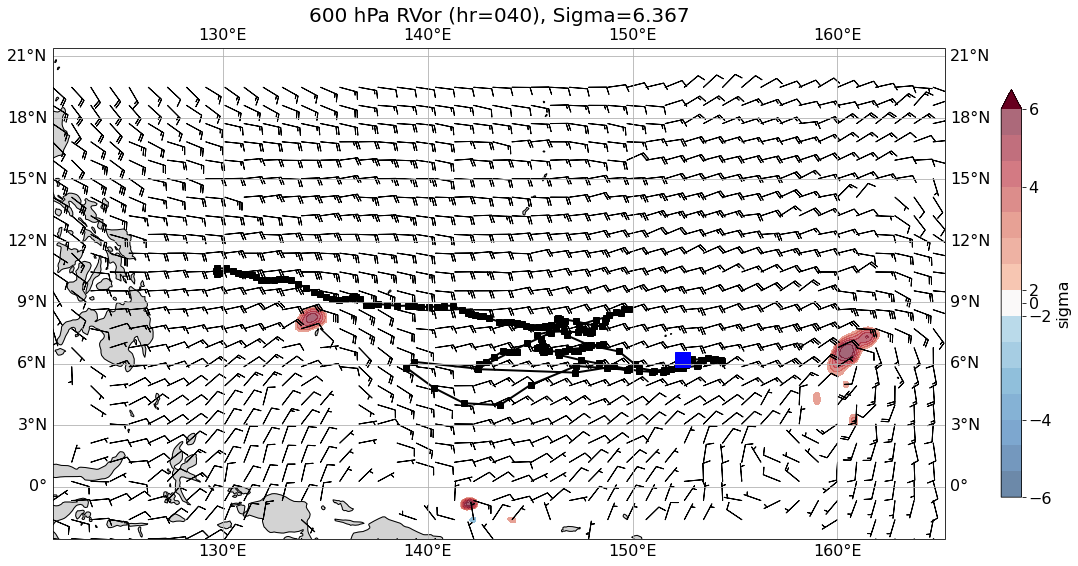

In [72]:
# select plotting area
plt_area=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)] # W,E,S,N
# plt_area=[145, np.max(lon), 0, 15] # W,E,S,N

# tsel=36
# for tsel in range(12,64):
for tsel in range(40,41):
    
    hr_tag = str(np.char.zfill(str(tsel), 3))
    print(hr_tag)
    
    iu = u[tsel,:,:]
    iv = v[tsel,:,:]
    pltvar=f_masked[tsel,:,:]
    
    # sigma=np.std(pltvar)
    sigma=np.max(np.abs(pltvar))
    # print("Sigma = ",sigma)
    # pltvar/=sigma

    # create figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
    ax.set_title(str(round(pres[ikread])) + ' hPa RVor (hr='+hr_tag+'), Sigma='+np.array2string(np.float16(sigma)), fontsize=20)

    # fill contour
    clevs = np.arange(2, 6, 0.5)
    clevs = np.concatenate((-1*np.flip(clevs),clevs))

    im = ax.contourf(lon, lat, pltvar, clevs, cmap='RdBu_r', alpha=0.6,
                     extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel('sigma')
            # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

    # wind barbs
    spacing=30#15 #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = iu * mps_to_kts
    vplt = iv * mps_to_kts
    # mask for speeds < 10 kts
    spd = np.sqrt(uplt**2+vplt**2)
    uplt=np.ma.masked_where(spd < 5, uplt, copy=False)

    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
                 uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2, length=6)

    # storm track
    plt.plot(clon, clat, color="black", linewidth=2)
    plt.plot(clon, clat, "s", color="black")
    # current time
    plt.plot(clon[tsel], clat[tsel], "s", color="blue", markersize=15)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    # ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_area)

    plt.show()
    # plt.savefig(figdir+'vort'+str(round(pres[ikread]))+'_smx'+str(nx_sm)+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
              # bbox_inches='tight', pad_inches=0.2)
    plt.close()